# CJ STRUCTURE FUNCS

In [1]:
#root='../'
import sys,os
import numpy as np
#sys.path.insert(1,root)
from tools import tex,checkdir,load,save,fill_between,com
import pylab as py
import matplotlib.gridspec as gridspec
from  matplotlib import rc
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'  
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import pandas as pd
from scipy import stats
from scipy.integrate import quad,fixed_quad
from scipy.optimize import root,leastsq,minimize
from PDF.CT10 import CT10
#from numba import jit,autojit

In [11]:
class PARAMS(object):
  
  def __init__(self):
    self.Lambda = 0.339
    self.Nf = 3.0
    self.CF = 4.0/3.0
    self.TR = 1.0/2.0
    self.CA = 3.0
    self.beta0 = 11.0-2*self.Nf/3.0
    self.beta1 = 102.0-38*self.Nf/3.0
    self.M2=0.939**2
   
  def alpi(self,mu):
    return 2.0/self.beta0/np.log(mu/self.Lambda)\
      -self.beta1*np.log(2*np.log(mu/self.Lambda))\
      /self.beta0**3/np.log(mu/self.Lambda)**2

par=PARAMS()
%timeit -n10 -r10 par.alpi(5.0)

10 loops, best of 10: 13.2 µs per loop


In [6]:
print par.CF

1.33333333333


In [3]:
class DISTRO(object):
  
  def __init__(self,root='./'):
    self.PDF=CT10(root+'PDF')
    self.flavmap={'g':0}
    self.flavmap.update({'u':1,'ub':-1})
    self.flavmap.update({'d':2,'db':-2})
    self.flavmap.update({'s':3,'sb':-3})
    self.flavmap.update({'c':4,'cb':-4})
    self.flavmap.update({'b':5,'bb':-5})
    
  def get_PDF(self,flav,x,Q):
    return self.PDF.get_pdf(self.flavmap[flav],x,Q)

  
distro=DISTRO()
%timeit -n10 -r10 distro.get_PDF('u',0.5,2.0)

10 loops, best of 10: 5.89 µs per loop


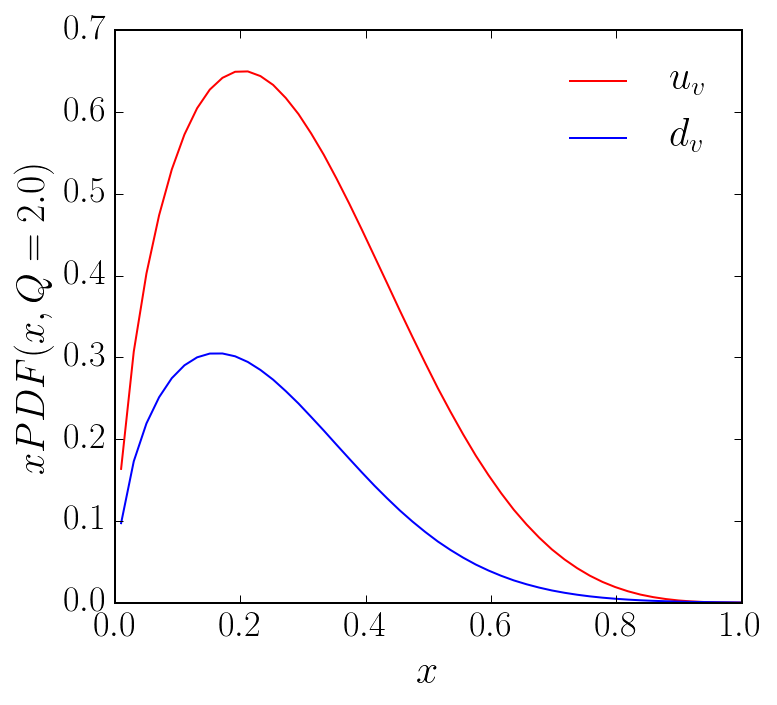

In [4]:
nrows,ncols=1,1
py.figure(figsize=(ncols*5.5,nrows*5))
ax=py.subplot(nrows,ncols,1)
X=np.linspace(1e-2,1)
xu =np.array([x*distro.get_PDF('u',x,2.0) for x in X])
xub=np.array([x*distro.get_PDF('ub',x,2.0) for x in X])
xd =np.array([x*distro.get_PDF('d',x,2.0) for x in X])
xdb=np.array([x*distro.get_PDF('db',x,2.0) for x in X])
ax.plot(X,xu-xub,'r-',label=r'$u_v$')
ax.plot(X,xd-xdb,'b-',label=r'$d_v$')
ax.legend(frameon=0,fontsize=20)
ax.set_xlabel(r'$x$',size=20)
ax.set_ylabel(r'$xPDF(x,Q=2.0)$',size=20)
ax.legend(frameon=0,fontsize=20)
py.tick_params(axis='both', which='major', labelsize=18)
py.tight_layout()

In [7]:
class F2STF(object):
  
  def __init__(self,par,distro):
    self.CF=par.CF
    self.TR=par.TR
    self.eU2=4.0/9.0
    self.eD2=1.0/9.0
    self.get_PDF=distro.get_PDF
    self.alpi=par.alpi
    
  def integrator(self,f,xmin,xmax,method,n=200):
    f=np.vectorize(f)
    if method=='quad':
      return quad(f,xmin,xmax)[0]
    elif method=='gauss':
      return fixed_quad(f,xmin,xmax,n=n)[0]
    
  def log_plus(self,z,f,x):
    return np.log(1-z)/(1-z)*(f(x/z)-f(x)) + 0.5*np.log(1-x)**2*f(x)/(1-x)

  def one_plus(self,z,f,x):
    return 1/(1-z)*(f(z)-f(1))+ np.log(1-x)*f(x)/(1-x)
    
  def Cq(self,z,f,x):
    try:
      return self.CF*(\
          2*self.log_plus(z,f,x)-1.5*self.one_plus(z,f,x)\
        +(-(1+z)*np.log(1-z)-(1+z*z)/(1-z)*np.log(z)+3+2*z)*f(x/z)\
        -(np.pi**2/3+4.5)*f(x)/(1-x))
    except:
      return 0
    
  def Cg(self,z,f,x):
    return self.TR*(((1-z)**2+z*z)*np.log((1-z)/z)-8*z*z+8*z-1)*f(x/z)    
  
  def qplus(self,x,Q):
    return self.eU2*(self.get_PDF('u',x,Q)+self.get_PDF('ub',x,Q))\
          +self.eD2*(self.get_PDF('d',x,Q)+self.get_PDF('db',x,Q))\
          +self.eD2*(self.get_PDF('s',x,Q)+self.get_PDF('sb',x,Q))

  def glue(self,x,Q):
    return 2*(self.eU2 + 2*self.eD2)*self.get_PDF('g',x,Q)
      
  def integrand(self,x,z,Q):
    return self.Cq(z,lambda y:self.qplus(y,Q),x)/z\
          +self.Cg(z,lambda y:self.glue(y,Q),x)/z
    
    
  def get_F2(self,x=None,Q=None,method='gauss',n=10):
    LO=self.qplus(x,Q)
    integrand=lambda z:self.integrand(x,z,Q)
    NLO=self.integrator(integrand,x,1,method,n=n)
    return x*(LO+self.alpi(Q)/2.0*NLO)
    
f2stf=F2STF(par,distro)
print 'gauss10=',f2stf.get_F2(x=0.5,Q=2.0,method='gauss',n=10)
print 'gauss50=',f2stf.get_F2(x=0.5,Q=2.0,method='gauss',n=50)
%timeit -n3 -r3 f2stf.get_F2(x=0.5,Q=2.0,method='gauss')
#print 'quad =',f2stf.get_F2(x=0.5,Q=2.0,method='quad')
#%timeit -n3 -r3 f2stf.get_F2(x=0.5,Q=2.0,method='quad')

gauss10= 0.136943746626
gauss50= 0.137181408083
3 loops, best of 3: 4.16 ms per loop


In [8]:
Q=2.0
X1=10**np.linspace(-3,0,100)
X2=np.linspace(1e-3,1,100)
X3=np.array([1e-3,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
X=np.unique(np.r_[X1,X2,X3])
F2=com(lambda x:f2stf.get_F2(x,Q),X,'F2') 

[******************100%****************]  F2  206 of 206 complete


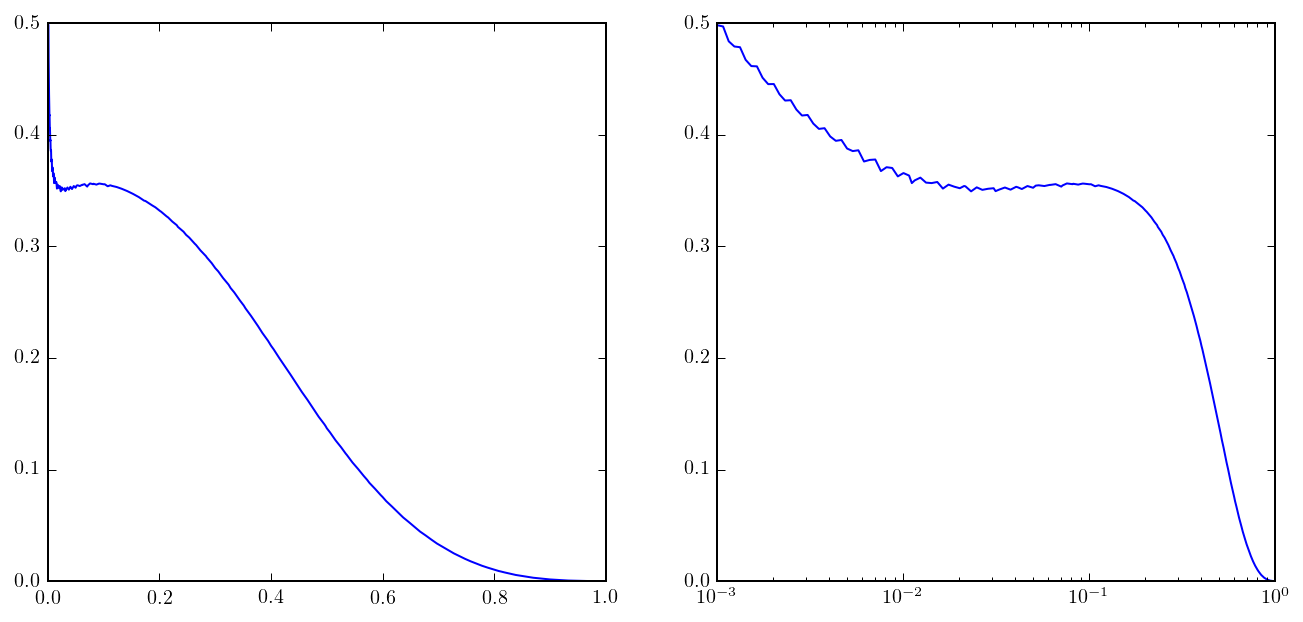

In [9]:
nrows,ncols=1,2
py.figure(figsize=(ncols*5.5,nrows*5))
ax=py.subplot(nrows,ncols,1)
ax.plot(X,F2,'b-',label=r'$F_2$')
ax=py.subplot(nrows,ncols,2)
ax.plot(X,F2,'b-',label=r'$F_2$')
ax.semilogx();

In [21]:
class F2STF_AA(object):
  
  def __init__(self,par,distro):
    self.CF=par.CF
    self.TR=par.TR
    self.eU2=4.0/9.0
    self.eD2=1.0/9.0
    self.get_PDF=distro.get_PDF
    self.alpi=par.alpi
    self.M2=par.M2
    
  def integrator(self,f,xmin,xmax,method,n=200):
    f=np.vectorize(f)
    if method=='quad':
      return quad(f,xmin,xmax)[0]
    elif method=='gauss':
      return fixed_quad(f,xmin,xmax,n=n)[0]
    
  def log_plus(self,z,f,x):
    return np.log(1-z)/(1-z)*(f(x/z)-f(x)) + 0.5*np.log(1-x)**2*f(x)/(1-x)

  def one_plus(self,z,f,x):
    return 1/(1-z)*(f(z)-f(1))+ np.log(1-x)*f(x)/(1-x)
    
  def Cq(self,z,f,x):
    try:
      return self.CF*(\
          2*self.log_plus(z,f,x)-1.5*self.one_plus(z,f,x)\
        +(-(1+z)*np.log(1-z)-(1+z*z)/(1-z)*np.log(z)+3+2*z)*f(x/z)\
        -(np.pi**2/3+4.5)*f(x)/(1-x))
    except:
      return 0
    
  def Cg(self,z,f,x):
    return self.TR*(((1-z)**2+z*z)*np.log((1-z)/z)-8*z*z+8*z-1)*f(x/z)    
  
  def qplus(self,x,Q):
    return self.eU2*(self.get_PDF('u',x,Q)+self.get_PDF('ub',x,Q))\
          +self.eD2*(self.get_PDF('d',x,Q)+self.get_PDF('db',x,Q))\
          +self.eD2*(self.get_PDF('s',x,Q)+self.get_PDF('sb',x,Q))

  def glue(self,x,Q):
    return 2*(self.eU2 + 2*self.eD2)*self.get_PDF('g',x,Q)

  def xi(self,x,Q):
    if self.TMC=='AQ':
      return 2*x/(1+(1+4*x**2*self.M2/Q**2)**0.5)
    else:
      return x
  
  def integrand(self,x,y,Q):
    return self.Cq(y,lambda z:self.qplus(z,Q),self.xi(x,Q))/y\
          +self.Cg(y,lambda z:self.glue(z,Q),self.xi(x,Q))/y
    
    
  def get_F2(self,x=None,Q=None,TMC='Massless',method='gauss',n=10):
    self.TMC=TMC
    LO=self.qplus(x,Q)
    integrand=lambda z:self.integrand(x,z,Q)
    NLO=self.integrator(integrand,x,1,method,n=n)
    return x*(LO+self.alpi(Q)/2.0*NLO)
    
f2stf=F2STF_AA(par,distro)
print 'gauss10=',f2stf.get_F2(x=0.8,Q=1.3,method='gauss',n=10)
print 'gauss10=',f2stf.get_F2(x=0.8,Q=1.3,method='gauss',n=10,TMC='AQ')
#%timeit -n3 -r3 f2stf.get_F2(x=0.5,Q=2.0,method='gauss')
#print 'quad =',f2stf.get_F2(x=0.5,Q=2.0,method='quad')
#%timeit -n3 -r3 f2stf.get_F2(x=0.5,Q=2.0,method='quad')

gauss10= 0.0195064280023
gauss10= 0.0404946450142


In [20]:
print f2stf.M2
f2stf.M2=0
print f2stf.M2

0.881721
0
